# PROJECT: 이제까지 만들었던 모델을 튜닝하고 배포하기
---

<br>

<br>

## 개요
CIFAR10 프로젝트를 기반으로 데이터를 수정하고 하이퍼파라미터 튜닝을 한 다음 배포하는 프로젝트이다. 이 번 프로젝트를 통해 **MLOps**의 기초 흐름을 파악해본다.  
* MLOps란?
    * **데이터 관리**: 데이터 수집, 전처리, 정제, 저장, 관리 등 데이터 관리에 대한 전반적인 프로세스와 도구를 포함한다.
    * **모델 개발**: 모델 설계, 훈련, 평가, 최적화 등 모델 개발에 대한 전반적인 프로세스와 도구를 포함한다.
    * **모델 배포**: 모델을 프로덕션 환경에 배포하기 위한 프로세스와 도구를 포함한다.
    * **모델 운영**: 모델이 프로덕션 환경에서 안정적으로 작동하도록 모니터링, 유지보수, 업데이트하는 프로세스와 도구를 포함한다.
    
<br>

## 목차
* 모델 고정해서 사용하기
* Data Centric AI 맛보기
* 하이퍼파라미터 튜닝
* 모델 배포하기 (옵션)
* TFLite 모델 만들기 (옵션)
* (추가미션) 박찬성님의 TFX 프로젝트 분석해보기

### 모델 고정해서 사용하기
---
이번 CIFAR10 프로젝트의 경우에는 모델을 고정해서 사용할 예정이므로 다음과 같은 그림으로 구성하도록 한다.  
![structure](./model_structure.png)

In [1]:
!pip install keras-tuner

In [2]:
# 필요한 라이브러리 import
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os

In [3]:
from tensorflow.keras.datasets import cifar10

# 데이터셋을 불러와서 학습/검증 데이터로 분할
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
# 데이터 형상 확인
x_train.shape

(50000, 32, 32, 3)

In [5]:
# 47520 인덱스 데이터 확인 - 문제 이해 전 시도
x_train[47520]

array([[[246, 246, 246],
        [242, 242, 242],
        [241, 241, 241],
        ...,
        [239, 239, 239],
        [238, 238, 238],
        [240, 240, 240]],

       [[249, 249, 249],
        [245, 245, 245],
        [245, 245, 245],
        ...,
        [242, 242, 242],
        [241, 241, 241],
        [242, 242, 242]],

       [[249, 249, 249],
        [244, 244, 244],
        [244, 244, 244],
        ...,
        [240, 240, 240],
        [240, 240, 240],
        [240, 240, 240]],

       ...,

       [[104, 104, 104],
        [ 96,  96,  96],
        [ 94,  94,  94],
        ...,
        [ 55,  55,  55],
        [ 58,  58,  58],
        [ 56,  56,  56]],

       [[ 90,  90,  90],
        [ 80,  80,  80],
        [ 69,  69,  69],
        ...,
        [ 78,  78,  78],
        [ 72,  72,  72],
        [ 64,  64,  64]],

       [[ 83,  83,  83],
        [ 75,  75,  75],
        [ 64,  64,  64],
        ...,
        [100, 100, 100],
        [102, 102, 102],
        [ 87,  87,  87]]

In [6]:
# 2405번째 이미지의 레이블 확인
y_train[2405]

array([7], dtype=uint8)

In [7]:
# 6877번째 이미지의 레이블 확인
y_train[6877]

array([4], dtype=uint8)

In [8]:
# 이미지의 픽셀 범위 확인
print("max pixel:", x_train.max())
print("min pixel:", x_train.min())

max pixel: 255
min pixel: 0


In [9]:
# 픽셀 값 정규화 : -1에서 1사이의 값으로
x_train = (x_train - 127.5) / 127.5

print("max pixel:", x_train.max())
print("min pixel:", x_train.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/conda/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


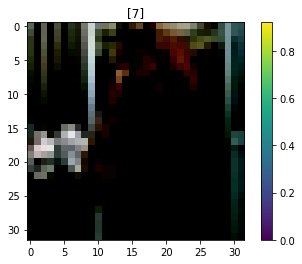

In [10]:
import matplotlib.pyplot as plt

# 2405번째 이미지 확인
plt.imshow(x_train[2405])
plt.title(y_train[2405])
plt.colorbar()   # 각 픽셀의 값과 그에 따른 색을 확인
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


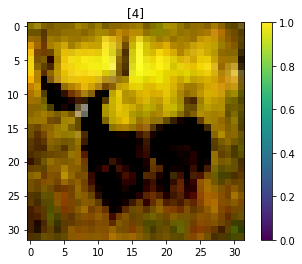

In [11]:
# 6877번째 이미지 확인
plt.imshow(x_train[6877])
plt.title(y_train[6877])
plt.colorbar()
plt.show()

labelerror에 나와있는 id에 대한 이미지와 레이블이 아닌, 정상적으로 매핑된 이미지가 나온다.  labelerrors 사이트에 나와있는 정보와 달라 나중에 다시 확인하도록 한다.

In [12]:
from tensorflow.keras import layers

# 모델 설계
model = tf.keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'))
model.add(layers.AveragePooling2D((2, 2), strides=2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D((2, 2), strides=2))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))


위에서 제시한 모델 구조를 설계한다.  
> 문제 이해를 못한 상황에서 한 작업이라 이 모델은 쓰지 않고 아래에서 다시 설계할 예정이다.

In [13]:
# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

### Data Centric AI 맛보기
---
Data Centric AI를 일일이 해볼만한 시간은 존재하지 않으니 사람들이 미리 검수했던 내용들을 기반으로 프로젝트를 진행하도록 한다.  
위에서 잠깐 확인했을 땐 레이블과 다르지 않은 것 같지만, 혹시 모르니 labelerrors에 있는 모든 id를 확인해보도록 한다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: unhashable type: 'numpy.ndarray'

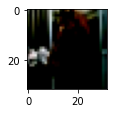

In [14]:
# 잘못 라벨링된 데이터의 인덱스로 이미지와 레이블 확인
error_idx = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966]
label_idx = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

plt.figure(figsize=(10, 12))

for i, v in enumerate(error_idx):
    plt.subplot(6, 6, i+1)
    plt.imshow(x_train[v])
    plt.title(f'{y_train[v]}: {label_idx[y_train[v]]}')
    plt.axis('off')

plt.show()

데이터 형식에 대한 에러가 발생한 것 같으므로, 디버깅을 진행해본다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7]


TypeError: unhashable type: 'numpy.ndarray'

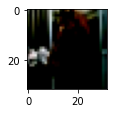

In [15]:
error_idx = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966]
label_idx = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

plt.figure(figsize=(10, 12))

for i, v in enumerate(error_idx):
    print(y_train[v])
    plt.subplot(6, 6, i+1)
    plt.imshow(x_train[v])
    plt.title(f'{y_train[v]}: {label_idx[y_train[v]]}')
    plt.axis('off')

plt.show()

`y_train[v]`값은 정상적으로 출력이 되는 것으로 보아 `label_idx[y_train[v]]`값에서 에러가 발생하는 것 같다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


TypeError: unhashable type: 'numpy.ndarray'

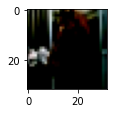

In [16]:
error_idx = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966]
label_idx = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

plt.figure(figsize=(10, 12))

for i, v in enumerate(error_idx):
    print(label_idx[int(y_train[v][0])])
    plt.subplot(6, 6, i+1)
    plt.imshow(x_train[v])
    plt.title(f'{y_train[v]}: {label_idx[y_train[v]]}')
    plt.axis('off')

plt.show()

`y_train[v]`의 값이 정수형이 아닌 문자형으로 반환이 되어, 정수형이 필요한 `label_idx[]`의 요소와 충돌이 발생한 것 같으니, `y_train[v]`의 값을 정수형으로 캐스팅시켜 보도록 한다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

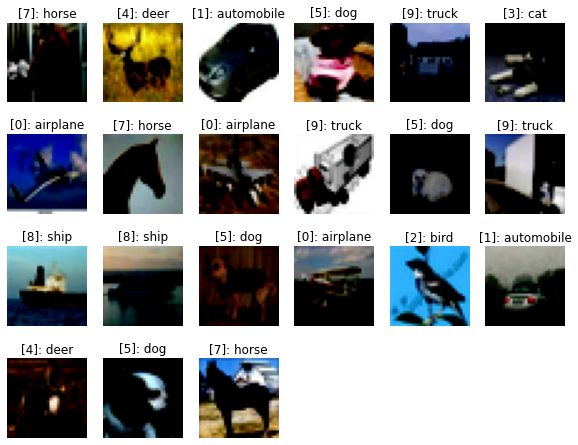

In [17]:
error_idx = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966]
label_idx = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

plt.figure(figsize=(10, 12))

for i, v in enumerate(error_idx):
    plt.subplot(6, 6, i+1)
    plt.imshow(x_train[v])
    plt.title(f'{y_train[v]}: {label_idx[int(y_train[v][0])]}')
    plt.axis('off')

plt.show()

정상적으로 레이블과 이미지가 출력이 됐지만, labelerrors에서 설명하는 것과 같은 라벨링이 잘못된 데이터는 보이지 않는다.

노드에서 진행하라고 했던 루브릭은 학습 데이터가 아닌 검증 데이터였다. 한 번 확인해보도록 한다.

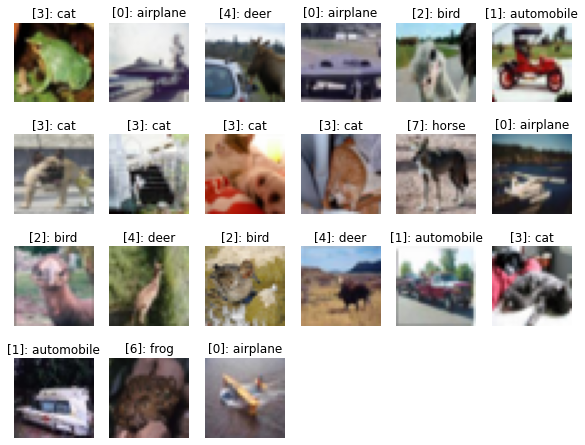

In [18]:
error_idx = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966]
label_idx = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

plt.figure(figsize=(10, 12))

for i, v in enumerate(error_idx):
    plt.subplot(6, 6, i+1)
    plt.imshow(x_test[v])
    plt.title(f'{y_test[v]}: {label_idx[int(y_test[v][0])]}')
    plt.axis('off')

plt.show()

시간이 없으니, 얼른 고쳐보도록 한다.

In [19]:
import numpy as np

# 올바른 레이블 리스트 생성
real_idx = [6, 8, 4, 1, 7, 9, 5, 9, 5, 5, 4, 8, 4, 2, 3, 2, 9, 5, 9, 3, 8, 5]

# 레이블 변경 작업
for i, v in enumerate(error_idx):
    y_test[v][0] = np.uint8(real_idx[i])

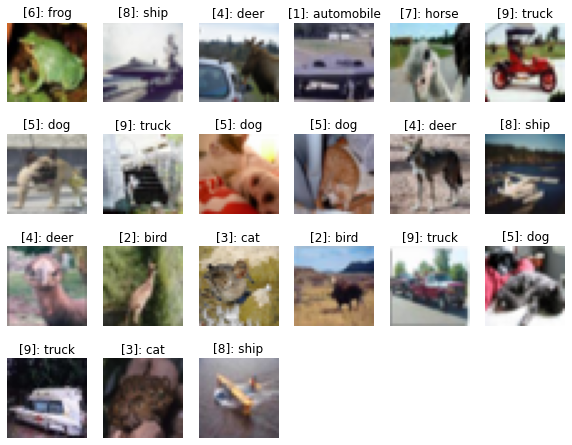

In [20]:
error_idx = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966]
label_idx = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

plt.figure(figsize=(10, 12))

for i, v in enumerate(error_idx):
    plt.subplot(6, 6, i+1)
    plt.imshow(x_test[v])
    plt.title(f'{y_test[v]}: {label_idx[int(y_test[v][0])]}')
    plt.axis('off')

plt.show()

이렇게 테스트 데이터에 있는 잘못 라벨링된 이미지를 급하게 수정을 진행하였다.

### 하이퍼 파라미터 튜닝
---
위에 있는 모델을 기반으로 KerasTuner로 하이퍼파라미터 튜닝을 진행한다. 튜닝한 하이퍼 파라미터로 학습을 진행하고 모델을 SavedModel 형식으로 저장하도록 한다.  

(주의사항)  
하이퍼 파라미터를 어느정도 범위로 주는지에 따라서 모델 튜닝속도가 달라지므로, 학습시간을 고려해서 하이퍼 파라미터 튜닝을 세팅한다.

In [21]:
import keras_tuner as kt

# 하이퍼 파라미터 튜닝(탐색 범위 지정) 클래스 정의
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

In [22]:
# 모델 설계 함수 정의
def build_model(hp):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'),
        layers.AveragePooling2D((2, 2), strides=2),  # output shape (None, 15, 15, 32)
        layers.BatchNormalization(),  # output shape (None, 15, 15, 32)

        layers.Conv2D(64, (3, 3), activation='relu'),  # output shape (None, 13, 13, 64)
        layers.AveragePooling2D((2, 2), strides=2),  # output shape (None, 6, 6, 64)
        layers.BatchNormalization(),  # output shape (None, 6, 6, 64)

        layers.Flatten(),  # output shape (None, 2304)
        layers.Dense(256, activation='relu'),  # output shape (None, 256)
        layers.Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.2)),  # output shape (None, 256)
        layers.Dense(10, activation='softmax')  # output shape (None, 10)
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:
from tensorflow.keras.utils import to_categorical

# 하이퍼 파라미터 튜닝 객체 생성
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# 레이블 인코딩
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# 최적의 하이퍼 파라미터 탐색
my_keras_tuner.search(
    x_train, y_train_encoded, validation_data=(x_test, y_test_encoded), epochs=3)

Trial 10 Complete [00h 00m 22s]
accuracy: 0.15710000693798065

Best accuracy So Far: 0.3587999939918518
Total elapsed time: 00h 05m 00s


In [24]:
# 튜닝된 하이퍼 파라미터를 모델에 반영
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)

# 모델 구조 확인
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_24 (Averag (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_25 (Averag (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_12 (Flatten)         (None, 2304)            

In [25]:
# 불필요한 코드
y_train_encoded = to_categorical(y_train)

# 모델 학습 시작
history = model.fit(x_train, y_train_encoded, batch_size=32, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3373 - accuracy: 0.5463
Epoch 2/5
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8596 - accuracy: 0.7001
Epoch 3/5
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6627 - accuracy: 0.7694
Epoch 4/5
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5047 - accuracy: 0.8230
Epoch 5/5
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3644 - accuracy: 0.8707


In [26]:
# 모델 평가
model.evaluate(x_test, y_test_encoded)

313/313 [==============================] - 2s 3ms/step - loss: 220.9782 - accuracy: 0.3048


[220.97817993164062, 0.30480000376701355]

정확도가 별로 안좋으니 다른 모델로 재시도하도록 한다.

In [27]:
model2 = build_model(best_hps)
history2 = model2.fit(x_train, y_train_encoded, batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3081 - accuracy: 0.5551
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8499 - accuracy: 0.7015
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6550 - accuracy: 0.7726
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4893 - accuracy: 0.8289
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3584 - accuracy: 0.8745
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2599 - accuracy: 0.9098
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1965 - accuracy: 0.9307
Epoch 8/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1599 - accuracy: 0.9442
Epoch 9/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1412 - accuracy: 0.9507
Epoch 10/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.127

In [28]:
model2.evaluate(x_test, y_test_encoded)

313/313 [==============================] - 1s 2ms/step - loss: 794.0442 - accuracy: 0.3176


[794.044189453125, 0.3176000118255615]

더 떨어졌다...시간이 없으니 모델 저장을 해보도록 한다.

In [29]:
save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/2'
fname = os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/2/model/assets


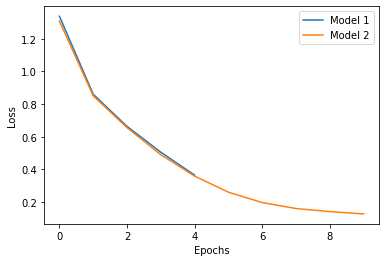

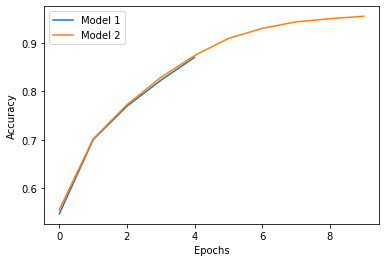

In [30]:
import matplotlib.pyplot as plt

# 학습 손실 그래프
plt.plot(history.history['loss'], label='Model 1')
plt.plot(history2.history['loss'], label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 학습 정확도 그래프
plt.plot(history.history['accuracy'], label='Model 1')
plt.plot(history2.history['accuracy'], label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
model3 = build_model(best_hps)
history3 = model3.fit(x_train, y_train_encoded, batch_size=32, epochs=50)

Epoch 1/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3152 - accuracy: 0.5553
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8478 - accuracy: 0.7050
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6521 - accuracy: 0.7715
Epoch 4/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4916 - accuracy: 0.8281
Epoch 5/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3610 - accuracy: 0.8745
Epoch 6/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2627 - accuracy: 0.9073
Epoch 7/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2045 - accuracy: 0.9277
Epoch 8/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1658 - accuracy: 0.9431
Epoch 9/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1461 - accuracy: 0.9486
Epoch 10/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.123

In [33]:
model3.evaluate(x_test, y_test_encoded)

313/313 [==============================] - 1s 3ms/step - loss: 906.9723 - accuracy: 0.3114


[906.9722900390625, 0.31139999628067017]

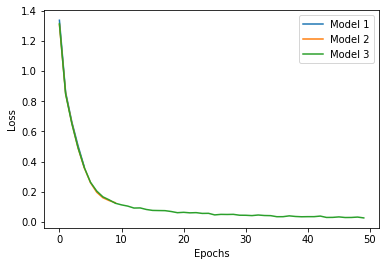

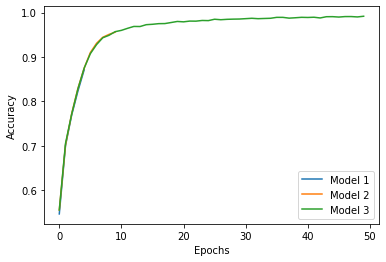

In [34]:
# 학습 손실 그래프
plt.plot(history.history['loss'], label='Model 1')
plt.plot(history2.history['loss'], label='Model 2')
plt.plot(history3.history['loss'], label='Model 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 학습 정확도 그래프
plt.plot(history.history['accuracy'], label='Model 1')
plt.plot(history2.history['accuracy'], label='Model 2')
plt.plot(history3.history['accuracy'], label='Model 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/3'
fname = os.path.join(save_path, 'model')
model3.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/3/model/assets


에폭을 늘리는 것과는 별 상관이 없는 것 같다...

### 회고
---
13, 14노드를 부리나케 진행하느라 기존에 해왔던대로 코드를 분석하면서 진행하지 못한 것에 대한 아쉬움이 크다. 전체적인 흐름은 파악이 됐으니, 다시 한 번 차근차근 노드를 곱씹어보는 시간을 가져야할 것 같다.